**<font color=black size=5 face=雅黑>引入第三方库</font>**

In [1]:
import re,math
from math import log
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn import datasets, metrics, model_selection, svm
from itertools import groupby
from collections import Counter,defaultdict
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier as KNN
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
import urllib
import zipfile
import os
import zlib
from joblib import dump, load

**<font color=black size=5 face=雅黑>读取CSV文件并拼接</font>**

In [2]:
CSV_FILE_PATH1 = './work/bad.csv'
CSV_FILE_PATH2 = './work/good.csv'
df1 = pd.read_csv(CSV_FILE_PATH1)
df1 = df1[:80000]
df2 = pd.read_csv(CSV_FILE_PATH2)
df2 = df2[:80000]
df3 = pd.concat([df1,df2],axis = 0,ignore_index=True)
df3.fillna(method='pad') 
print(df3.head())
print(df3.tail())
print(df3.info())

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3018: DtypeWarning: Columns (25) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


                                Flow ID        Src IP  Src Port        Dst IP  \
0  10.0.2.108-93.189.89.83-49159-8080-6    10.0.2.108   49159.0  93.189.89.83   
1  93.189.89.83-10.0.2.108-8080-49159-6  93.189.89.83    8080.0    10.0.2.108   
2  10.0.2.108-93.189.89.83-49161-8080-6    10.0.2.108   49161.0  93.189.89.83   
3  93.189.89.83-10.0.2.108-8080-49161-6  93.189.89.83    8080.0    10.0.2.108   
4  10.0.2.108-93.189.89.83-49163-8080-6    10.0.2.108   49163.0  93.189.89.83   

   Dst Port  Protocol               Timestamp  Flow Duration  \
0    8080.0       6.0  01/01/1970 08:01:56 上午       101711.0   
1   49159.0       6.0  01/01/1970 08:01:56 上午        48486.0   
2    8080.0       6.0  01/01/1970 08:02:19 上午        96373.0   
3   49161.0       6.0  01/01/1970 08:02:19 上午        46107.0   
4    8080.0       6.0  01/01/1970 08:02:42 上午       101756.0   

   Total Fwd Packet  Total Bwd packets  ...  Active Mean  Active Std  \
0               5.0                4.0  ...          0.0

**<font color=black size=5 face=雅黑>热力图查看特征之间的相关性</font>**

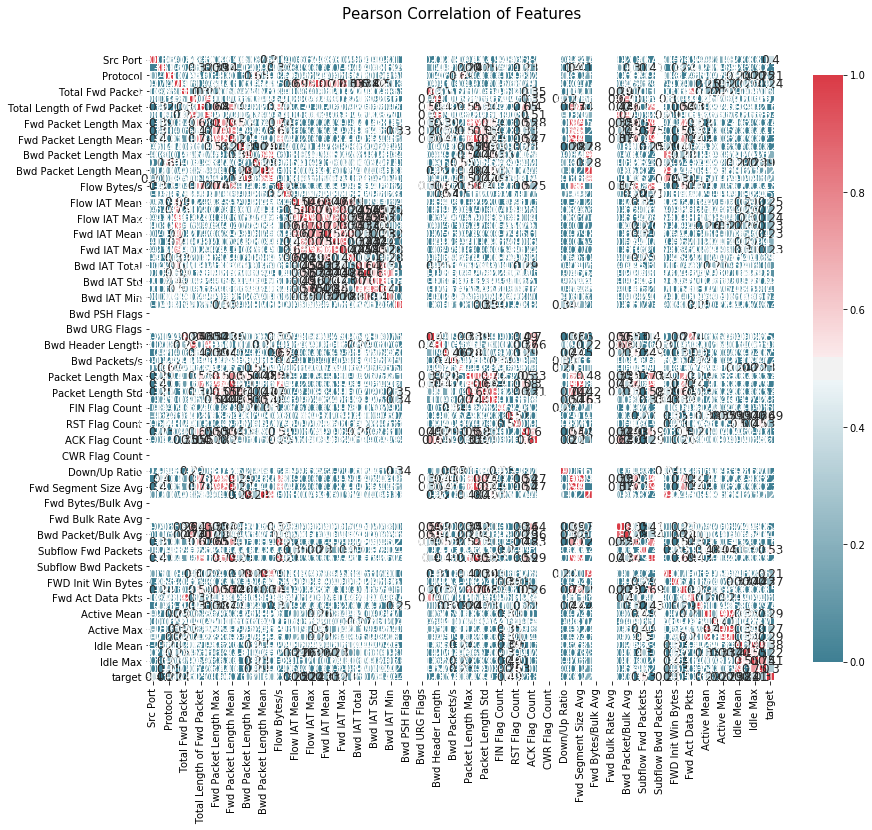

In [ ]:
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    _ = sns.heatmap(df.corr(),cmap = colormap, square=True,cbar_kws={'shrink':.9 }, ax=ax, annot=True, linewidths=0.1,vmin=0,vmax=1.0, linecolor='white',annot_kws={'fontsize':12 })
    plt.title('Pearson Correlation of Features', y=1.05, size=15)
    plt.show()
correlation_heatmap(df3)

**<font color=black size=5 face=雅黑>训练模型数据集导入并分割训练集和测试集</font>**

In [3]:
data_lite = df3[['Src Port', 'Dst Port', 'Protocol' , 'Flow Duration', 'Total Fwd Packet', 
'Total Bwd packets','Total Length of Fwd Packet','Total Length of Bwd Packet','Fwd Packet Length Max','Fwd Packet Length Min','Fwd Packet Length Std','Bwd Packet Length Max','Bwd Packet Length Min',
'Bwd Packet Length Mean','Bwd Packet Length Std','Flow Bytes/s','Flow Packets/s','Flow IAT Mean',
'Flow IAT Std','Flow IAT Max','Fwd IAT Total','Fwd IAT Mean','Fwd IAT Std','Fwd IAT Max',
'Fwd IAT Min','Bwd IAT Total','Bwd IAT Mean','Bwd IAT Std','Bwd IAT Max','Bwd IAT Min','Fwd PSH Flags','Bwd PSH Flags','Fwd URG Flags',
'Bwd URG Flags','Fwd Header Length','Bwd Header Length','Fwd Packets/s','Bwd Packets/s','Packet Length Min','Packet Length Max','Packet Length Mean',
'Packet Length Std','Packet Length Variance','FIN Flag Count','SYN Flag Count','RST Flag Count','PSH Flag Count','ACK Flag Count','URG Flag Count','CWR Flag Count','ECE Flag Count',
'Down/Up Ratio','Average Packet Size','Fwd Segment Size Avg','Bwd Segment Size Avg','Fwd Bytes/Bulk Avg','Fwd Packet/Bulk Avg','Fwd Bulk Rate Avg','Bwd Bytes/Bulk Avg','Bwd Packet/Bulk Avg','Bwd Bulk Rate Avg','Subflow Fwd Packets',
'Subflow Fwd Bytes','Subflow Bwd Packets','Subflow Bwd Bytes','FWD Init Win Bytes','Bwd Init Win Bytes','Fwd Act Data Pkts','Active Mean','Active Std','Active Max',
'Active Min','Idle Mean','Idle Min','target']]
# 下面看一下数据的前五行是不是我们想要的结果
data_dummies = data_lite
print(data_lite.head())
print(data_lite.tail())
data_dummies=pd.DataFrame(data_dummies,dtype=np.float)
print(data_dummies.info())
features = data_dummies.loc[:,'Src Port':'Idle Min']
X = features.values
y = data_dummies['target'].values

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=9)  # 拆分成训练集和测试集

   Src Port  Dst Port  Protocol  Flow Duration  Total Fwd Packet  \
0   49159.0    8080.0       6.0       101711.0               5.0   
1    8080.0   49159.0       6.0        48486.0               2.0   
2   49161.0    8080.0       6.0        96373.0               5.0   
3    8080.0   49161.0       6.0        46107.0               2.0   
4   49163.0    8080.0       6.0       101756.0               5.0   

   Total Bwd packets  Total Length of Fwd Packet  Total Length of Bwd Packet  \
0                4.0                       841.0                      1206.0   
1                0.0                         0.0                         0.0   
2                4.0                       892.0                      1359.0   
3                0.0                         0.0                         0.0   
4                4.0                       855.0                      1248.0   

   Fwd Packet Length Max  Fwd Packet Length Min  ...  FWD Init Win Bytes  \
0                  574.0          

**<font color=black size=8 face=雅黑>随机森林（未调参，精度已为1）</font>**

**<font color=black size=5 face=雅黑>随机森林模型训练</font>**

In [4]:
# 经过调参后，用60棵树最大深度为10的随机森林拟合数据
forest = RandomForestClassifier(n_estimators=40,max_depth=3, criterion='entropy', random_state=66, min_samples_split = 2,min_samples_leaf=1)
forest.fit(X_train, y_train)
# 模型的评估
y_test_pre = forest.predict(X_test)
test_accuracy = forest.score(X_test, y_test)
score = cross_val_score(forest,X_train,y_train,cv=10).mean()
print(score)
print("这里是随机森林模型的评估：")
print("\n测试集的准确率：%.6f" %test_accuracy)
test_precision = precision_score(y_test, y_test_pre)
print("\n测试集的精确率：%.6f" %test_precision)
test_recall = recall_score(y_test, y_test_pre)
print("\n测试集的召回值：%.6f" %test_recall)
test_f1 = f1_score(y_test, y_test_pre)
print("\n测试集的F1值：%.6f" %test_f1)
print("\n测试集的漏报率：%.6f" %(1-test_recall))
print("\n测试集的误报率：%.6f" %(1-test_precision))
print("\n")
print(classification_report(y_test,y_test_pre))


0.9997053571428569
这里是随机森林模型的评估：

测试集的准确率：0.999604

测试集的精确率：0.999416

测试集的召回值：0.999791

测试集的F1值：0.999604

测试集的漏报率：0.000209

测试集的误报率：0.000584


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     24025
         1.0       1.00      1.00      1.00     23975

    accuracy                           1.00     48000
   macro avg       1.00      1.00      1.00     48000
weighted avg       1.00      1.00      1.00     48000



**<font color=black size=5 face=雅黑>模型的保存</font>**

In [ ]:
dump(forest, 'train_model.pkl')
print('模型保存成功！')

模型保存成功！


**<font color=black size=5 face=雅黑>特征重要度排序</font>**

In [25]:
print("这里是特征的重要度排序：\n")
feat_labels = data_lite.columns[0:-1]
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))

# 可视化
x_columns = data_lite.columns[0:-1]
plt.figure(figsize=(10,6))
plt.title("Features Importance Level",fontsize = 18)
plt.ylabel("import level",fontsize = 15,rotation=90)
for i in range(x_columns.shape[0]):
    plt.bar(i,importances[indices[i]],color='teal',align='center')
    plt.xticks(np.arange(x_columns.shape[0]),feat_labels[indices],rotation=45,fontsize=14)
index=np.arange(10)
num_list = importances[indices]
for a,b in zip(index,num_list):   #柱子上的数字显示
    plt.text(a,b,'%.5f'%b,ha='center',va='bottom',fontsize=10);
plt.show()

这里是特征的重要度排序：

 1) Fwd IAT Min                    0.178671
 2) Fwd IAT Max                    0.093982
 3) Fwd Packets/s                  0.084235
 4) Flow Packets/s                 0.069904
 5) Fwd IAT Total                  0.069646
 6) Flow IAT Max                   0.049513
 7) Bwd Packets/s                  0.045915
 8) Bwd Header Length              0.036723
 9) Flow Duration                  0.034192
10) Fwd PSH Flags                  0.029479
11) FWD Init Win Bytes             0.023828
12) Subflow Fwd Packets            0.022311
13) Bwd Packet Length Mean         0.022244
14) Idle Mean                      0.020595
15) Src Port                       0.020323
16) Fwd Packet Length Max          0.019185
17) Average Packet Size            0.018814
18) Bwd IAT Std                    0.017388
19) Flow IAT Mean                  0.016778
20) Flow Bytes/s                   0.016373
21) Bwd Init Win Bytes             0.016017
22) Idle Min                       0.013401
23) Subflow Fwd By

**<font color=black size=5 face=雅黑>决策树模型的训练及分数评估</font>**

In [20]:
#用最大深度为15的决策树拟合数据
go_dating_tree = tree.DecisionTreeClassifier(max_depth=3)
go_dating_tree.fit(X_train,y_train)
# 模型的评估
y_test_pre = go_dating_tree.predict(X_test)
test_accuracy = go_dating_tree.score(X_test, y_test)
print("这里是决策树模型的评估：")
print("\n测试集的准确率：%.6f" %test_accuracy)
test_precision = precision_score(y_test, y_test_pre)
print("\n测试集的精确率：%.6f" %test_precision)
test_recall = recall_score(y_test, y_test_pre)
print("\n测试集的召回值：%.6f" %test_recall)
test_f1 = f1_score(y_test, y_test_pre)
print("\n测试集的F1值：%.6f" %test_f1)
print("\n测试集的漏报率：%.6f" %(1-test_recall))
print("\n测试集的误报率：%.6f" %(1-test_precision))
print("\n")
print(classification_report(y_test,y_test_pre))

这里是决策树模型的评估：

测试集的准确率：0.999979

测试集的精确率：1.000000

测试集的召回值：0.999958

测试集的F1值：0.999979

测试集的漏报率：0.000042

测试集的误报率：0.000000


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     24025
         1.0       1.00      1.00      1.00     23975

    accuracy                           1.00     48000
   macro avg       1.00      1.00      1.00     48000
weighted avg       1.00      1.00      1.00     48000



**<font color=black size=5 face=雅黑>KNN模型的训练及分数评估</font>**

In [21]:
knc = KNN(n_neighbors=6, )
knc.fit(X_train, y_train)
y_predict = knc.predict(X_test)
acc = knc.score(X_test, y_test)
print('\nKNN准确率', acc)
pre = precision_score(y_test, y_predict, average='macro')
print('\nKNN精确率', pre)
recall = recall_score(y_test, y_predict, average='macro')
print('\nKNN召回率', recall)
print('\nKNNF1值', f1_score(y_test, y_predict, average='macro'))
print("\n测试集的漏报率：", 1-recall)
print("\n测试集的误报率：", 1-pre)


KNN准确率 0.99975

KNN精确率 0.9997503848233973

KNN召回率 0.9997497393117831

KNNF1值 0.9997499995828987

测试集的漏报率： 0.00025026068821687453

测试集的误报率： 0.00024961517660271326
